<a href = 'https://www.facebook.com/fea.dev/'> 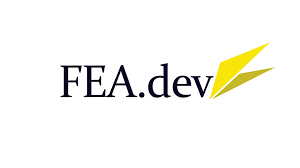<a/>

# Prevendo faixa de renda de estudantes com Machine Learning (KNN)

***

Olá! Seja muito bem vindo ao Workshop de Machine Learning Introdutório do FEA.dev.

O arquivo que você acabou de abrir e está vendo agora se chama Notebook (extensão `.ipynb`) e ele serve para escrevermos textos junto com códigos em Python!

##### Instruções de uso: Clique nessa célula e vá apertando `Shift` + `Enter`. Você deverá compleatar o código em Python substituindo os `...` com as partes corretas.


Dataset usado:
> https://www.kaggle.com/benroshan/factors-affecting-campus-placement/data

_OBS: Caso você tenha recebido esse Notebook pelo email, o dataset já está baixado, ele se chama "Placement_Data_Full_Class.csv"._ 

_OBS: Clique em download para baixar o arquivo CSV e extraia o arquivo zip para dentro da mesma pasta que esse notebook._

## Índice

1. [Importando bibliotecas que usaremos](#Importando-bibliotecas-que-usaremos)
2. [Análise básica do dataset](#Análise-básica-do-dataset)
3. [Tratamento dos dados](#Tratamento-dos-dados)
4. [Matriz de correlação](#Matriz-de-correlação)
5. [Análise gráfica](#Análise-gráfica)
6. [Aplicando modelo de Machine Learning: KNN](#Aplicando-modelo-de-Machine-Learning:-KNN)
7. [Visualizando a fronteira](#Visualizando-a-fronteira)
8. [Como usar na prática?](#Como-usar-na-prática?)







## Importando bibliotecas que usaremos

In [1]:
# Bibliotecas para ler/manipular/ver nossos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para criar nosso modelo de ML
from sklearn import preprocessing, model_selection, neighbors
from sklearn.preprocessing import StandardScaler

# Biblioteca para plotar nosso modelo
from mlxtend.plotting import plot_decision_regions

##### OBS: Caso vc não tenha alguma dessas bibliotecas, descomente a célula abaixo tirando o jogo da velha e rode-a com base no seguinte modelo:
> `pip install <NOME DA BIBLIOTECA>`

In [2]:
# pip install pandas

## Análise básica do dataset

Lendo o arquivo csv

In [3]:
df = pd.read_csv('Placement_Data_Full_Class.csv')
df.drop(['sl_no'], 1, inplace = True)

Printando as primeiras linhas

In [4]:
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


Vendo algumas informações com `.info()` e `.describe()`

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          148 non-null    float64
dtypes: float64(6), object(8)
memory usage: 23.6+ KB


In [6]:
df.describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


Incluindo dados categóricos (`object`) no `.describe()`

In [7]:
df.describe(include=['object'])

,gender,ssc_b,hsc_b,hsc_s,degree_t,workex,specialisation,status
count,215,215,215,215,215,215,215,215
unique,2,2,2,3,3,2,2,2
top,M,Central,Others,Commerce,Comm&Mgmt,No,Mkt&Fin,Placed
freq,139,116,131,113,145,141,120,148


## Tratamento dos dados

Filtrando os dados: removendo aquelas linhas que possuem "Others" na coluna "degree_t", pois eles correspondem a uma parcela muito pequena, podemos ver esse tipo de dado apenas como uma "sujeira" para nosso modelo

In [8]:
df = df[df['degree_t'] != 'Others']

Inserindo 0 para os salários faltantes

In [9]:
df['salary'].fillna(0, inplace = True)

Para fins desse exercício, vamos separar os alunos em 2 grupos: entre aqueles que ganham mais que a mediana dos salários e aqueles que ganham menos.

Podemos ver algumas informações da coluna `"salary"` pelo método `.describe()`. Inclusive a mediana:

In [10]:
df['salary'].describe()

count       204.000000
mean     202544.117647
std      154464.984840
min           0.000000
25%           0.000000
50%      240000.000000
75%      285500.000000
max      940000.000000
Name: salary, dtype: float64

Descobrimos que a mediana é 240.000. Agora resta dividir os grupos

In [11]:
df.loc[df['salary'] < 240000, 'salary'] = 0
df.loc[df['salary'] >= 240000, 'salary'] = 1

Para checar, veja os valores únicos da coluna `"salary"` com o método `.unique()`

In [12]:
df['salary'].unique()

array([1., 0.])

Agora, vamos tratar os dados categóricos com a função do pandas `pd.get_dummies()`. Ela cria novas colunas para cada tipo de valor que temos em uma determinada coluna. Caso tenha dúvidas, reveja nossa playlist de pré-requisitos.

In [13]:
df_dummy = pd.get_dummies(df)

In [14]:
df_dummy.head()

,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary,gender_F,gender_M,ssc_b_Central,ssc_b_Others,...,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR,status_Not Placed,status_Placed
0,67.00,91.00,58.00,55.0,58.80,1.0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,1
1,79.33,78.33,77.48,86.5,66.28,0.0,0,1,1,0,...,0,1,0,1,0,1,1,0,0,1
2,65.00,68.00,64.00,75.0,57.80,1.0,0,1,1,0,...,0,0,1,0,1,0,1,0,0,1
3,56.00,52.00,52.00,66.0,59.43,0.0,0,1,1,0,...,0,1,0,1,1,0,0,1,1,0
4,85.80,73.60,73.30,96.8,55.50,1.0,0,1,1,0,...,1,0,1,0,1,0,1,0,0,1


## Matriz de correlação

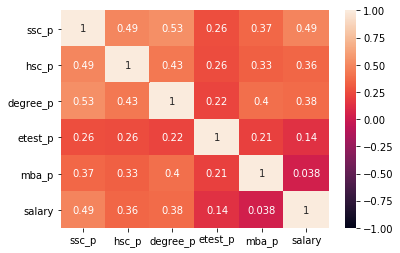

In [15]:
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

Note que a coluna `salary` tem maior correlação com as coluas `ssc_p` e `hsc_p`

## Análise gráfica

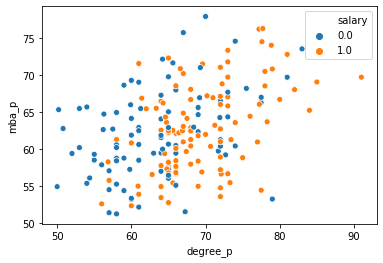

In [16]:
sns.scatterplot(data=df, x='degree_p', y='mba_p', hue='salary')
plt.show()

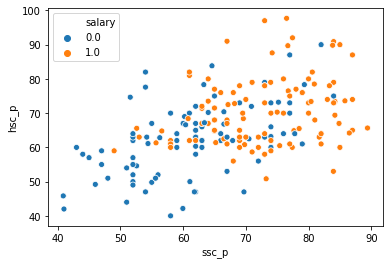

In [17]:
sns.scatterplot(data=df, x='ssc_p', y='hsc_p', hue='salary')
plt.show()

## Aplicando modelo de Machine Learning: KNN

Definindo colunas de features (X) e targets (y)

In [18]:
# Colunas dos "features"
X = np.array(df_dummy.drop(['salary'], 1))

# Colunas do "target"
y = np.array(df_dummy['salary'])

Separando o Dataset em treino e teste

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=0)

Normalizando nossos valores

In [20]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Definindo nosso modelo (KNN)

In [21]:
clf = neighbors.KNeighborsClassifier(n_neighbors=19, metric='euclidean')

Treinando nosso modelo

In [22]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

Testando sua acurácia no dataset de teste

In [23]:
accuracy = clf.score(X_test, y_test)
accuracy

0.926829268292683

## Visualizando a fronteira

Vamos visualizar usando as duas variáveis com a fronteira mais 'evidente'. Mas elas não são as únicas que influenciam!

In [24]:
def knn_comparison(data, k):
    x = data[['ssc_p','hsc_p']].values
    y = data['salary'].astype(int).values
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(x, y)
    plot_decision_regions(x, y, clf=knn)
    plt.xlabel('ssc_p')
    plt.ylabel('hsc_p')
    plt.title('K='+ str(k))
    plt.show()

Teste para alguns valores de k!

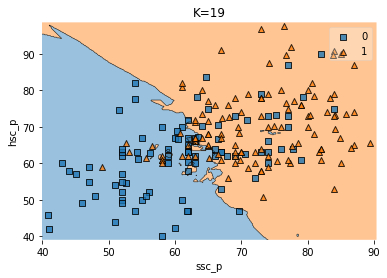

In [25]:
knn_comparison(df_dummy, k = 19)

## Como usar na prática?

In [26]:
df_dummy.head(1).T

,0
ssc_p,67.0
hsc_p,91.0
degree_p,58.0
etest_p,55.0
mba_p,58.8
salary,1.0
gender_F,0.0
gender_M,1.0
ssc_b_Central,0.0
ssc_b_Others,1.0


In [30]:
exemplo = np.array([45,45,60,60,50,1,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0])

exemplo = exemplo.reshape(1,-1)

exemplo = sc_X.transform(exemplo)

predicao = clf.predict(exemplo)

print(predicao)

[0.]


<div align='center'><a href='https://www.facebook.com/fea.dev/'/ style='display:inline-block'>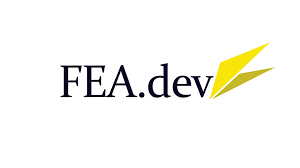<a/><div/>